In [33]:
# ---------- 4. ROBUSTNESS ANALYSIS (WITH PLOTS) ----------
from ema_workbench import load_results
import matplotlib.pyplot as plt
import seaborn as sns
#from ema_workbench.analysis import RobustnessEvaluator
#from ema_workbench.em_framework.optimization import ScalarOutcome
import pandas as pd
import numpy as np
from ema_workbench import Policy
from ema_workbench import Scenario


# --- Load results
experiments, outcomes = load_results("results/promising_resample_1000.tar.gz")
policies = experiments["policy"].unique()
outcome_names = list(outcomes.keys())


Regret analysis

In [34]:
# setup a dataframe for the outcomes
# we add scenario and policy as additional columns
# we need scenario because regret is calculated on a scenario by scenario basis
# we add policy because we need to get the maximum regret for each policy.
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    # policy is non numeric, so max is not defined for this
    best = x.min(numeric_only=True)
    
    # max_P is minimized so best performance is minimum.
    #best['max_P'] = x.max_P.min()    
    
    # again we need to handle max_P a bit different
    regret = best + x.loc[:, best.index]
    #regret['max_P'] = x.max_P - best.max_P

    # we add policy back into our regret dataframe
    # so we know the regret for each policy
    regret['policy'] = x.policy
    return regret

# we want to calculate regret on a scenario by scenario basis
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

# as last step, we calculate the maximum and mean regret for each policy
max_regret = regret.groupby('policy').max()
mean_regret= regret.groupby('policy').mean()

C:\Users\tlwal\AppData\Local\Temp\ipykernel_27076\24291359.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\tlwal\AppData\Local\Temp\ipykernel_27076\24291359.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\tlwal\AppData\Local\Temp\ipykernel_27076\24291359.py:29: FutureWarning: The default of observed=False is deprecated and 

In [23]:
mean_regret.head()

,Gelderland Expected Annual Damage,Gelderland Dike Investment Costs,Gelderland Expected Number of Deaths,Overijssel Expected Annual Damage,Overijssel Dike Investment Costs,Overijssel Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
policy,,,,,,,,
pol_000,2.028636e+07,5.964842e+08,0.016201,2.977901e+07,5.453532e+07,0.023488,377300000.0,0.000000
pol_001,1.140955e+06,7.276984e+08,0.000850,5.989287e+08,6.320800e+06,0.460612,30700000.0,0.000000
pol_002,9.964534e+06,7.041446e+08,0.007059,1.237487e+08,4.142030e+07,0.034774,303800000.0,3658.893349
pol_003,5.888030e+07,5.315274e+08,0.015612,1.476735e+08,8.453408e+06,0.017138,363600000.0,9559.063623
pol_004,0.000000e+00,6.087663e+08,0.000000,5.659732e+08,2.503721e+07,0.053180,0.0,34245.723013


In [35]:
# Normalize regret columns (min-max scaling)
for df in [mean_regret, max_regret]:
    for col in df.columns:
        mn, mx = df[col].min(), df[col].max()
        norm_col = col + "_norm"
        df[norm_col] = (df[col] - mn) / (mx - mn) if mx > mn else 0.0

# Overall scores
mean_norm_cols = [col for col in mean_regret.columns if col.endswith("_norm")]
max_norm_cols = [col for col in max_regret.columns if col.endswith("_norm")]

mean_regret["overall_mean_regret"] = mean_regret[mean_norm_cols].mean(axis=1)
max_regret["overall_max_regret"] = max_regret[max_norm_cols].max(axis=1)
max_regret["overall_max_regret_mean"] = max_regret[max_norm_cols].mean(axis=1)


In [25]:
mean_regret.head()

,Gelderland Expected Annual Damage,Gelderland Dike Investment Costs,Gelderland Expected Number of Deaths,Overijssel Expected Annual Damage,Overijssel Dike Investment Costs,Overijssel Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland Expected Annual Damage_norm,Gelderland Dike Investment Costs_norm,Gelderland Expected Number of Deaths_norm,Overijssel Expected Annual Damage_norm,Overijssel Dike Investment Costs_norm,Overijssel Expected Number of Deaths_norm,RfR Total Costs_norm,Expected Evacuation Costs_norm,overall_mean_regret
policy,,,,,,,,,,,,,,,,,
pol_000,2.028636e+07,5.964842e+08,0.016201,2.977901e+07,5.453532e+07,0.023488,377300000.0,0.000000,0.033930,0.521472,0.024139,0.032749,0.520105,0.046653,0.249653,0.000000,0.178588
pol_001,1.140955e+06,7.276984e+08,0.000850,5.989287e+08,6.320800e+06,0.460612,30700000.0,0.000000,0.001908,0.867004,0.001266,0.997238,0.060282,1.000000,0.020314,0.000000,0.368502
pol_002,9.964534e+06,7.041446e+08,0.007059,1.237487e+08,4.142030e+07,0.034774,303800000.0,3658.893349,0.016666,0.804979,0.010518,0.191991,0.395027,0.071267,0.201019,0.094272,0.223217
pol_003,5.888030e+07,5.315274e+08,0.015612,1.476735e+08,8.453408e+06,0.017138,363600000.0,9559.063623,0.098481,0.350419,0.023261,0.232535,0.080620,0.032803,0.240588,0.246291,0.163125
pol_004,0.000000e+00,6.087663e+08,0.000000,5.659732e+08,2.503721e+07,0.053180,0.0,34245.723013,0.000000,0.553815,0.000000,0.941391,0.238781,0.111409,0.000000,0.882349,0.340968


In [43]:
# Sort for convenience
#df_mean_regret = mean_regret.sort_values("overall_mean_regret").reset_index(drop=True)
#df_max_regret = max_regret.sort_values("overall_max_regret").reset_index(drop=True)

# Show top rows
#print("Top policies by MEAN regret:")
#display(df_mean_regret.head())

#print("Top policies by MAX regret:")
#display(df_max_regret.head())

# Save if needed
#df_mean_regret.to_csv("results/mean_regret_scores.csv", index=False)
#df_max_regret.to_csv("results/max_regret_scores.csv", index=False)

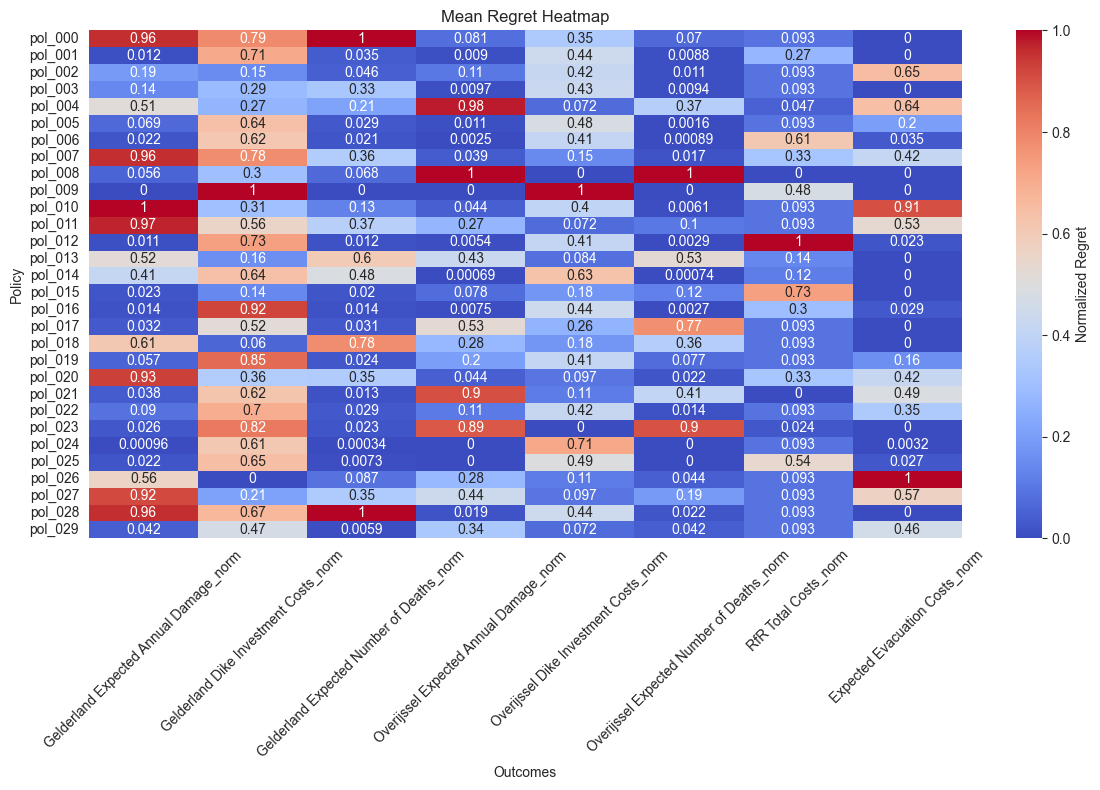

In [36]:
#For both mean and max regret, create a heatmap of the first 20 polices from the sorted dataframe
plt.figure(figsize=(12, 8)) 
#sns.heatmap(df_mean_regret.head(20)[mean_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
#plt.title("Mean Regret Heatmap (Top 20 Policies)")

sns.heatmap(mean_regret[mean_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
plt.title("Mean Regret Heatmap")

plt.xlabel("Outcomes")
plt.ylabel("Policy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



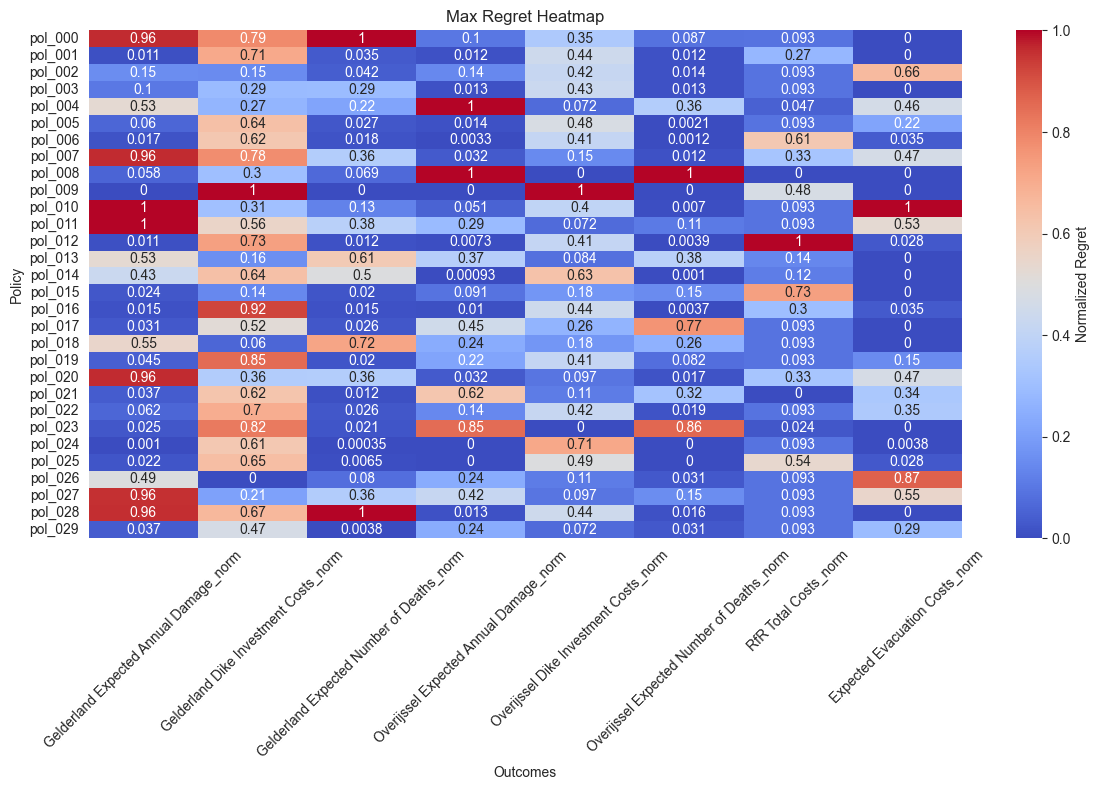

In [38]:
plt.figure(figsize=(12, 8))
#sns.heatmap(df_max_regret.head(20)[max_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
#plt.title("Max Regret Heatmap (Top 20 Policies)")

sns.heatmap(max_regret[max_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
plt.title("Max Regret Heatmap")

plt.xlabel("Outcomes")
plt.ylabel("Policy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

StopIteration: 

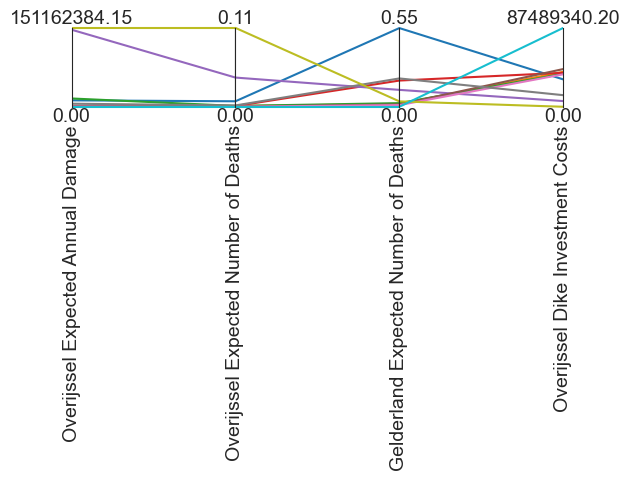

In [40]:
# Select only the relevant columns for the parallel coordinates plot
selected_cols = [
    "Overijssel Expected Annual Damage",
    "Overijssel Expected Number of Deaths",
    "Gelderland Expected Number of Deaths",
    "Overijssel Dike Investment Costs",
]

#mean_regret_top20_selected = df_mean_regret.head(20)[selected_cols]
mean_regret_selected = mean_regret[selected_cols]

# Get limits for the selected columns
limits_selected = parcoords.get_limits(mean_regret_selected)

# Create parallel axes for the selected outcomes
paraxes_selected = parcoords.ParallelAxes(limits_selected)

# Plot all rows in the selected mean regret DataFrame as parallel coordinates
colors = iter(sns.color_palette())
for i, row in mean_regret_selected.iterrows():
    color = next(colors)
    paraxes_selected.plot(row, label=f'Policy {i}', color=color)

paraxes_selected.legend()
plt.title("Parallel Coordinates Plot\nSelected Outcomes Only")
plt.xlabel("Outcomes")
plt.ylabel("Mean Regret")
plt.show()

StopIteration: 

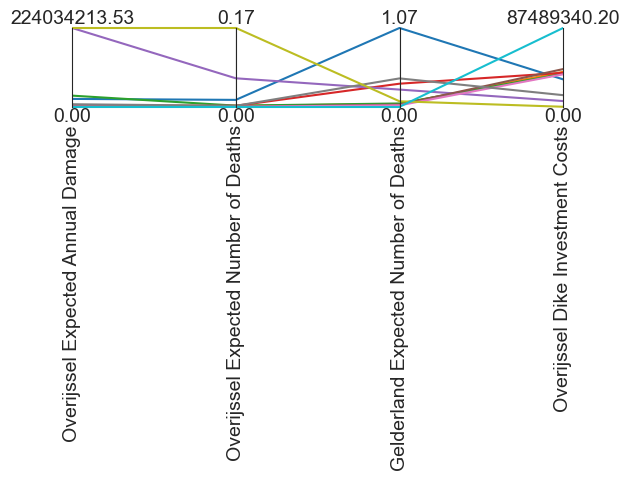

In [41]:
# Same for max regret

# Select only the relevant columns for the parallel coordinates plot
selected_cols = [
    "Overijssel Expected Annual Damage",
    "Overijssel Expected Number of Deaths",
    "Gelderland Expected Number of Deaths",
    "Overijssel Dike Investment Costs",
]

#max_regret_top20_selected = df_max_regret.head(20)[selected_cols]
max_regret_selected = max_regret[selected_cols]

# Get limits for the selected columns
limits_selected = parcoords.get_limits(max_regret_selected)

# Create parallel axes for the selected outcomes
paraxes_selected = parcoords.ParallelAxes(limits_selected)

# Plot all rows in the selected mean regret DataFrame as parallel coordinates
colors = iter(sns.color_palette())
for i, row in max_regret_selected.iterrows():
    color = next(colors)
    paraxes_selected.plot(row, label=f'Policy {i}', color=color)

paraxes_selected.legend()
plt.title("Parallel Coordinates Plot\nSelected Outcomes Only")
plt.xlabel("Outcomes")
plt.ylabel("Max Regret")
plt.show()

Old stuff